# Software Reliability Growth Modeling: Weibull More S-Shaped
### Advanced Statistics, Dynamic Programming and Stochastic Control Course Project   

Artur Samigullin  

### Abstract
Modelling software reliability used to properly manage product quality and release dates in software development process. Several classes of models have been proposed, including Software Reliability Growth Models, which model reliability estimating the errors that still remain in the software using the history of the detection of errors. 
Project focused on measuring performance of Weibull distribution based Software Reliability Growth Model by applying it to open data of development Tizen OS.

In [1]:
# data manipulation packages import
import numpy as np
import pandas as pd
import pickle

# statistical and optimization packages import
from sklearn.utils import resample
import scipy as sp
from scipy import stats

# visualisation packages and comands
import seaborn
%matplotlib inline
%precision 6

'%.6f'

In [2]:
# importing author's package for SRGMs
from SRMlib.sklearn_model import abs_accuracy
from SRMlib.models import Weibull_S_Shaped
from SRMlib.sklearn_model import SoftwareReliabilityGrowthModel as SRGM

In [3]:
# surpess sklearn warnings
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [4]:
data = pd.read_csv('./Datasets/bugs-1-tizen.csv', sep=';')

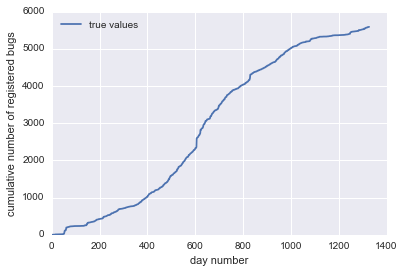

In [5]:
seaborn.plt.plot(data.x, data.y, label='true values')
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('cumulative number of registered bugs')
seaborn.plt.legend(loc=2)
seaborn.plt.savefig(open('./PNG/cum_bugs.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

Functions below help to convert your data to number of bugs registered per day from cumulative number of bugs and vice versa.

In [6]:
def to_differences(cumsums):
    return pd.Series(np.diff(cumsums), index=range(1,len(cumsums))).append(pd.Series(cumsums[0], index=[0]))

In [7]:
def to_cumsums(differences):
    return np.cumsum(differences)

In [8]:
data['y_dif'] = to_differences(data.y)

In [9]:
data.y_dif.describe()

count    1327.000000
mean        4.212509
std         8.803797
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max       224.000000
Name: y_dif, dtype: float64

#### Extremely high values

We can see a very big difference between 3rd and 4th quantiles.  
It means that we have some extremely high observations - **outliers**.  
In a figure below we can see points that far from normal valued points cloud.  

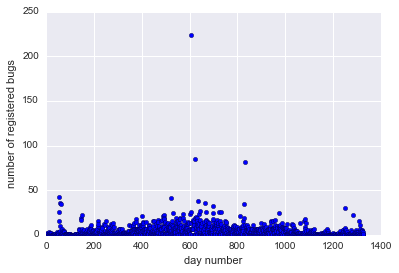

In [10]:
seaborn.plt.scatter(data.x, data.y_dif)
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('number of registered bugs')
seaborn.plt.ylim(ymin=0)
seaborn.plt.xlim(xmin=0)
seaborn.plt.savefig(open('./PNG/bugs_per_day.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

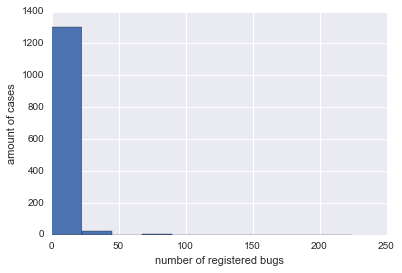

In [11]:
seaborn.plt.hist(data.y_dif)
seaborn.plt.xlabel('number of registered bugs')
seaborn.plt.ylabel('amount of cases')
seaborn.plt.ylim(ymin=0)
seaborn.plt.xlim(xmin=0)
seaborn.plt.savefig(open('./PNG/bugs_per_day_hist.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

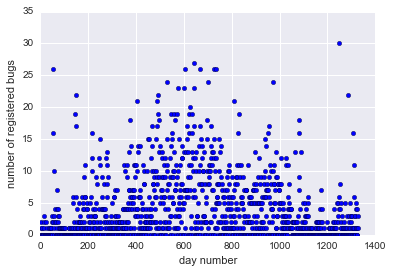

In [12]:
dt = data[(data.y_dif > data.y_dif.mean() - 3*data.y_dif.std()) & (data.y_dif < data.y_dif.mean() + 3*data.y_dif.std())]
seaborn.plt.scatter(dt.x, dt.y_dif)
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('number of registered bugs')
seaborn.plt.ylim(ymin=0)
seaborn.plt.xlim(xmin=0)
seaborn.plt.savefig(open('./PNG/bugs_per_day_cleaned.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

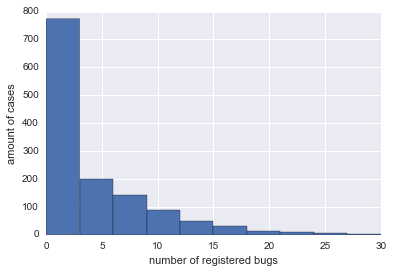

In [13]:
seaborn.plt.hist(dt.y_dif)
seaborn.plt.xlabel('number of registered bugs')
seaborn.plt.ylabel('amount of cases')
seaborn.plt.ylim(ymin=0)
seaborn.plt.xlim(xmin=0)
seaborn.plt.savefig(open('./PNG/bugs_per_day_hist_cleaned.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

#### To events / dates
Following function *to_events* helps to represent data as a bug registration events with 'day of registration' attribute.  
Function *to_dates* represents data as a time series with summarized amount of registered bugs

In [14]:
def to_events(dates):
    days = []
    num = 0
    for i in dates:
        for j in range(int(i)):
            days.append(num)
        num+=1
    return pd.Series(days)

In [15]:
def to_dates(events, dates_len=None):
    events = pd.DataFrame(events)
    if dates_len == None:
        dates_len = events[events.columns[0]].iloc[-1] + 1
    events['counts'] = 0
    dates = pd.DataFrame(index=np.arange(dates_len).astype(int))
    c = events.groupby(by=events.columns[0]).count()
    c['day'] = c.index
    c = c[c.day > 0]
    dates['day'] = dates.index
    return pd.merge(dates, c, how='left', on='day')['counts'].fillna(0)

In [16]:
dt_events = to_events(data.y_dif)

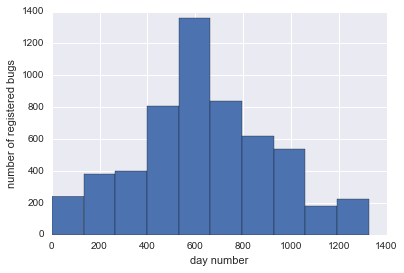

In [17]:
seaborn.plt.hist(dt_events)
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('number of registered bugs')
seaborn.plt.savefig(open('./PNG/days_of_bugs.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

### Model : Weibul More S-Shaped Model
In our study we use More S-Shaped version of Weibull model:
$$ a \times \Big(1 - (1 + b \times t^{c}) \times e ^{-b \times t^{c}} \Big)$$
where *a* > 0 is an expected cumulative total number of defects, *b* > 0 is a defect detection rate, *c* > 0 is a defect detection rate booster.

In [18]:
model = SRGM(Weibull_S_Shaped)
model.fit(data.x, data.y)

SoftwareReliabilityGrowthModel(approx_func=<function Weibull_S_Shaped at 0x11780b9d8>)

In [19]:
print ('a=', model.popt[0], ' ', 
       '\nb=', model.popt[1], ' ',
       '\nc=', model.popt[2], ' ' )

a= 5682.09034041   
b= 3.48646119704e-05   
c= 1.67116257149  


In [20]:
data['y_predicted'] = model.predict(data.x)

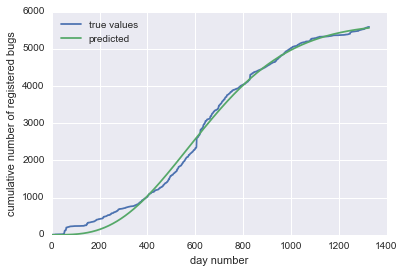

In [162]:
seaborn.plt.plot(data.x, data.y, label='true values')
seaborn.plt.plot(data.x, data.y_predicted, label='predicted')
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('cumulative number of registered bugs')
seaborn.plt.legend(loc='best')
seaborn.plt.savefig(open('./PNG/predicted_vs_true.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

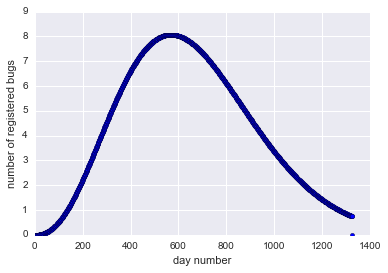

In [22]:
seaborn.plt.scatter(data.x, to_differences(data['y_predicted']))
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('number of registered bugs')
seaborn.plt.ylim(ymin=0)
seaborn.plt.xlim(xmin=0)
seaborn.plt.savefig(open('./PNG/bugs_per_day_predicted.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

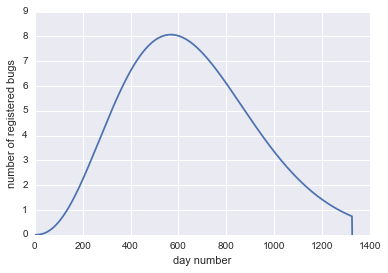

In [24]:
seaborn.plt.plot(data.x, to_differences(data['y_predicted']))
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('number of registered bugs')
seaborn.plt.ylim(ymin=0)
seaborn.plt.xlim(xmin=0)
seaborn.plt.savefig(open('./PNG/bugs_per_day_predicted_plt.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

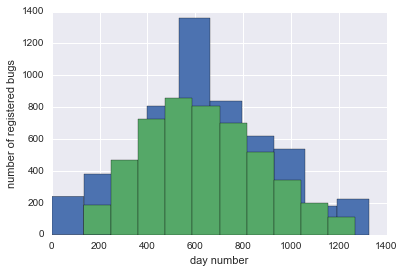

In [25]:
seaborn.plt.hist(dt_events)
seaborn.plt.hist(to_events(to_differences(data['y_predicted'])))
seaborn.plt.xlabel('day number')
seaborn.plt.ylabel('number of registered bugs')
seaborn.plt.savefig(open('./PNG/days_of_bugs_predicted.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

In [26]:
GoF0 = model.goodness_of_fit(X=data.x, y=data.y)
print('Goodness of Fit (GoF):', GoF0)

Goodness of Fit (GoF): 20761.527049949476


In [27]:
AcFP0 = model.accuracy_of_final_point(data.x.iloc[-1], data.y.iloc[-1])
print('Accuracy of Final Point (AcFP):', AcFP0)

Accuracy of Final Point (AcFP): 0.498631240404


In [28]:
PA0 = model.predictive_ability(data.x, data.y)
print('Predictive Ability (PA):', PA0)

Predictive Ability (PA): (73.3032, 'normal')


# Testing robustness for noise
Sometimes discovered bugs can be registered in bugtracker not in discovering day. Because of that we need to test our model with changed dataset. New dataset generated as follow:
1. Get number of bugs registered at each day 
2. For every discovered bug generate $Shift$ ~ $\mathcal{N}(0, \sigma)$, that shows possible shift for registration. Negative shift shows that bug registered with delay, and possitive shift shows possible delay for registering this bug.
3. Recalculate number of registered bugs for each day

Data that generated with described algorithm preserves one of model characteristics - expected cumulative total number
of defects.

Bugs that will move out interesting time period will be dropped down, because they will not change parameter $a$ too much.

### This functions generate noised set

In [29]:
def add_gaussian_noise(event, sigma):
    return event + np.round(np.random.normal(0, sigma))

In [30]:
def noised_series(events):
    return events.apply(lambda x : add_gaussian_noise(x, events.name[0]))

In [31]:
import itertools

In [32]:
def noised_set(events, sigma_min=1, sigma_max=2, sigma_step=1, max_iterations=10):
    sigmas = range(sigma_min, sigma_max+1, sigma_step)
    iterations = range(1, max_iterations+1)
    indexes = list(itertools.product(sigmas, iterations))
    noised_df = pd.DataFrame(dict.fromkeys(indexes, events)).apply(noised_series1, axis=0)
    return noised_df

In [33]:
events_x = to_events(data.y_dif)

### This part generates noised set and dumps it to disk

In [34]:
%%time
n_set = noised_set1(events_x, sigma_max=10, max_iterations=1000)

CPU times: user 7min 7s, sys: 3.01 s, total: 7min 10s
Wall time: 1h 12min 15s


In [40]:
with open('./noised_set.pickle', 'wb+') as f:
    pickle.dump(file=f, obj=n_set )

In [80]:
noised_set = pd.DataFrame()
for c in list(itertools.product(n_set.columns.levels[0], n_set.columns.levels[1])):
    gh = to_dates(n_set[c[0], c[1]].values, dates_len=1327)
    noised_set[c] = np.cumsum(gh)

In [81]:
with open('./noised_set_preprocessed.pickle', 'wb+') as f:
    pickle.dump(file=f, obj=noised_set)

### You can load a noised set dump by next block

In [34]:
with open('./noised_set_preprocessed.pickle', 'rb+') as f:
    noised_set = pickle.load(f)

In [35]:
noised_set.head()

,"(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 5)","(1, 6)","(1, 7)","(1, 8)","(1, 9)","(1, 10)",...,"(10, 991)","(10, 992)","(10, 993)","(10, 994)","(10, 995)","(10, 996)","(10, 997)","(10, 998)","(10, 999)","(10, 1000)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,2.0,1.0,0.0,1.0,1.0,1.0,3.0,2.0,1.0,...,0.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0
3,1.0,3.0,1.0,0.0,3.0,3.0,3.0,4.0,3.0,2.0,...,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0
4,4.0,4.0,2.0,1.0,4.0,4.0,3.0,4.0,4.0,3.0,...,1.0,1.0,2.0,2.0,1.0,2.0,2.0,3.0,0.0,2.0


### In folowing part we generate a table for noise test results

In [36]:
exp_result = {'Sigma':[], 'Num':[], 'GoF':[], 'AcFP':[]}

In [39]:
def fitting(y):
    l = len(y) - 1
    model = SRGM()
    model.fit(data.x,y)
    #GoF = model.goodness_of_fit(data.x, y)
    AcFP = model.accuracy_of_final_point(data.x[l], y[l])
    return (AcFP)

### Next part calculates GoF, AcFP and PA for noise test and dumps it to disk
Calculations with PA takes very long time

In [40]:
z = {}
for col in noised_set.columns:
    z[col] = fitting(noised_set[col])

In [41]:
for k in z.keys():
    exp_result['Sigma'].append(k[0])
    exp_result['Num'].append(k[1])
    exp_result['GoF'].append(z[k][0])
    exp_result['AcFP'].append(z[k][1])

In [50]:
metrics = pd.DataFrame(exp_result)

In [52]:
metrics = metrics.sort_values(['Sigma', 'Num'])

In [54]:
with open('metrics_df.srgm', 'wb+') as file:
    pickle.dump(obj=metrics, file=file)

In [51]:
with open('./metrics_df.srgm', 'rb+') as file:
    metrics = pickle.load(file)

In [56]:
mMetrics = {'mGoF':[], 'mAcFP':[], 'GoF_':[], 'AcFP_':[]}
for s in range(0,11):
    if s == 0:
        GoF = GoF0
        AcFP = AcFP0
    else:
        x = metrics[metrics.Sigma == s]
        GoF = x['GoF'].mean()
        AcFP = x['AcFP'].mean()
    mMetrics['mGoF'].append(GoF)
    mMetrics['mAcFP'].append(AcFP)
    mMetrics['GoF_'].append(abs_accuracy(GoF0, GoF))
    mMetrics['AcFP_'].append(abs_accuracy(AcFP0, AcFP))

In [57]:
mMetrics = pd.DataFrame(mMetrics)

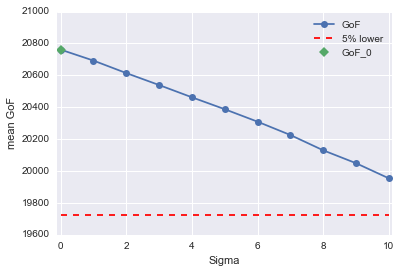

In [107]:
seaborn.plt.plot(list(range(0,11)), mMetrics.mGoF, 'o-', label='GoF')
seaborn.plt.plot(list(range(0,11)), [(GoF0 - GoF0*0.05) for x in range(0,11)], 'r--', label='5% lower')
seaborn.plt.plot(0, GoF0, 'D', label='GoF_0')
seaborn.plt.xlabel('Sigma')
seaborn.plt.ylabel('mean GoF')
seaborn.plt.xlim(xmin=-0.1, xmax=10.1)
seaborn.plt.ylim(ymax=21000)
seaborn.plt.legend(loc='best')
seaborn.plt.savefig(open('./PNG/mean_GoF.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

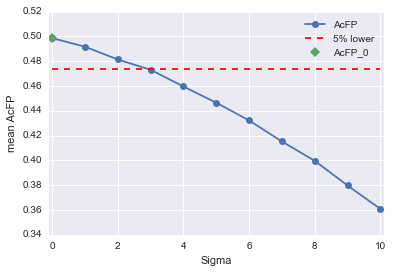

In [105]:
seaborn.plt.plot(list(range(0,11)), mMetrics.mAcFP, 'o-', label='AcFP')
seaborn.plt.plot(list(range(0,11)), [(AcFP0 - AcFP0*0.05) for x in range(0,11)], 'r--', label='5% lower')
seaborn.plt.plot(0, AcFP0, 'D', label='AcFP_0')
seaborn.plt.xlabel('Sigma')
seaborn.plt.ylabel('mean AcFP')
seaborn.plt.ylim(ymax=0.52, ymin=0.34)
seaborn.plt.xlim(xmin=-0.1, xmax=10.1)
seaborn.plt.legend(loc='best')
seaborn.plt.savefig(open('./PNG/mean_AcFP.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

In [109]:
def calculate_pa(y):
    model = SRGM()
    model.fit(data.x,y)
    return model.predictive_ability(data.x, y)

In [117]:
pa_result = {'pa':[], 'sigma':[]}
for i in range(1,11):
    indexes = np.random.uniform(1, 1000, 10).astype(int)
    for j in indexes:
        pa_result['pa'].append(calculate_pa(noised_set[(i,j)]))
        pa_result['sigma'].append(i)

In [118]:
pa_result = pd.DataFrame(pa_result)

In [136]:
pa_result['mode'] = pa_result['pa'].apply(lambda x: x[1])
pa_result['pa'] = pa_result['pa'].apply(lambda x: x[0])

In [141]:
pa_result.head()

,pa,sigma,mode
0,73.3032,1,normal
1,73.3032,1,normal
2,73.2278,1,normal
3,73.3032,1,normal
4,73.3032,1,normal


In [139]:
pa_result[pa_result['mode'] != 'normal']

,pa,sigma,mode


In [145]:
mPA = {'mPA':[], 'PA_':[]}
for s in range(0,11):
    if s == 0:
        PA = PA0[0]
    else:
        x = pa_result[pa_result.sigma == s]
        PA = x['pa'].mean()
    mPA['mPA'].append(PA)
    mPA['PA_'].append(abs_accuracy(PA0[0], PA))

In [148]:
mPA = pd.DataFrame(mPA)

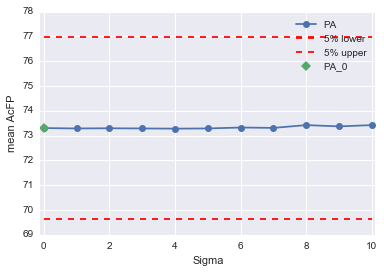

In [160]:
seaborn.plt.plot(list(range(0,11)), mPA['mPA'], 'o-', label='PA')
seaborn.plt.plot(list(range(0,11)), [((PA0[0]) - (PA0[0])*0.05) for x in range(0,11)], 'r--', label='5% lower')
seaborn.plt.plot(list(range(0,11)), [((PA0[0]) + (PA0[0])*0.05) for x in range(0,11)], 'r--', label='5% upper')
seaborn.plt.plot(0, PA0[0], 'D', label='PA_0')
seaborn.plt.xlabel('Sigma')
seaborn.plt.ylabel('mean AcFP')
seaborn.plt.ylim(ymax=78)
seaborn.plt.xlim(xmin=-0.1, xmax=10.1)
seaborn.plt.legend(loc='best')
seaborn.plt.savefig(open('./PNG/mean_PA.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

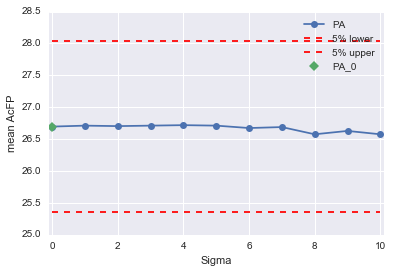

In [156]:
seaborn.plt.plot(list(range(0,11)), 100 - mPA['mPA'], 'o-', label='PA')
seaborn.plt.plot(list(range(0,11)), [((100 - PA0[0]) - (100 - PA0[0])*0.05) for x in range(0,11)], 'r--', label='5% lower')
seaborn.plt.plot(list(range(0,11)), [((100 - PA0[0]) + (100 - PA0[0])*0.05) for x in range(0,11)], 'r--', label='5% upper')
seaborn.plt.plot(0, 100 - PA0[0], 'D', label='PA_0')
seaborn.plt.xlabel('Sigma')
seaborn.plt.ylabel('mean AcFP')
#seaborn.plt.ylim(ymax=0.52, ymin=0.34)
seaborn.plt.xlim(xmin=-0.1, xmax=10.1)
seaborn.plt.legend(loc='best')
seaborn.plt.savefig(open('./PNG/mean_PA.png', 'wb+'), format='png', dpi=300)
seaborn.plt.show()

### With next block of code you can load noise test metrics dump

In [ ]:
with open('./metrics.pickle', 'rb+') as f:
    exp_result = pickle.load(f)

In [ ]:
metric_df.head()